**Задача:** классификация текстов Шекспира по жанрам

# Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gensim.downloader as downloader # Для скачивания предобученного word2vec

In [ ]:
import nltk # Библиотека для работы с текстовыми данными
from nltk import pos_tag # Функция, определяющая часть речи слова
from nltk.corpus import stopwords # Стоп-слова, который нужно удалить из текста
from nltk.tokenize import word_tokenize # Токенизатор, разделяющий текст на отдельные слова
from nltk.stem import WordNetLemmatizer # Лемматизатор - объект, приводящий слово к начальной форме

nltk.download('wordnet') # Загрузка базы данных английских слов, частей речи и т.п. для работы лемматизатора, токенизатора и т.п.
nltk.download('stopwords') # Загрузка набора стоп слов
nltk.download('punkt') # Загрузка данных для токенизатора
nltk.download('averaged_perceptron_tagger') # Инструмент для маркировки частей речи

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Загрузка данных

In [ ]:
data = pd.read_csv("shakespeare_plays.csv")
data

,Unnamed: 0,play_name,genre,character,act,scene,sentence,text,sex
0,0,All's Well That Ends Well,Comedy,Countess,1,1,1,"In delivering my son from me, I bury a second ...",female
1,1,All's Well That Ends Well,Comedy,Bertram,1,1,2,"And I in going, madam, weep o'er my father's d...",male
2,2,All's Well That Ends Well,Comedy,Bertram,1,1,3,"anew: but I must attend his majesty's command, to",male
3,3,All's Well That Ends Well,Comedy,Bertram,1,1,4,"whom I am now in ward, evermore in subjection.",male
4,4,All's Well That Ends Well,Comedy,Lafeu,1,1,5,"You shall find of the king a husband, madam; you,",male
...,...,...,...,...,...,...,...,...,...
108088,108088,Titus Andronicus,Tragedy,Lucius,5,3,201,"And, being so, shall have like want of pity.",male
108089,108089,Titus Andronicus,Tragedy,Lucius,5,3,202,"See justice done on Aaron, that damn'd Moor,",male
108090,108090,Titus Andronicus,Tragedy,Lucius,5,3,203,By whom our heavy haps had their beginning:,male
108091,108091,Titus Andronicus,Tragedy,Lucius,5,3,204,"Then, afterwards, to order well the state,",male


# Предобработка данных

Удалим все столбцы кроме необходимых для классификации и подготовки данных

In [ ]:
data = data[['play_name', 'genre', 'act', 'scene', 'text']]

Проверка на наличие пропусков

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108093 entries, 0 to 108092
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   play_name  108093 non-null  object
 1   genre      108093 non-null  object
 2   act        108093 non-null  int64 
 3   scene      108093 non-null  int64 
 4   text       108093 non-null  object
dtypes: int64(2), object(3)
memory usage: 4.1+ MB


Данные устроены следующим образом: пьеса состоит из актов, акты из сцен, сцена из предложений. У каждой пьесы только один жанр.

Классифицировать будем не предложения, а сцены, для сохранения большего контекста.

Сгруппируем данные: все предложения в рамках каждой сцены соберём в одно, сопоставиви каждой сцены жанр пьесы, из которой она взята

In [ ]:
scenes = data.groupby(['play_name', 'act', 'scene']).agg({
    'text': lambda x: ' '.join(x),
    'genre': 'first'
}).reset_index()


In [ ]:
scenes

,play_name,act,scene,text,genre
0,A Midsummer Night's Dream,1,1,"Now, fair Hippolyta, our nuptial hour Draws on...",Comedy
1,A Midsummer Night's Dream,1,2,Is all our company here? You were best to call...,Comedy
2,A Midsummer Night's Dream,2,1,"How now, spirit! whither wander you? Over hill...",Comedy
3,A Midsummer Night's Dream,2,2,"Come, now a roundel and a fairy song; Then, fo...",Comedy
4,A Midsummer Night's Dream,3,1,"Are we all met? Pat, pat; and here's a marvell...",Comedy
...,...,...,...,...,...
748,Winter's Tale,4,3,"I, that please some, try all, both joy and ter...",Comedy
749,Winter's Tale,4,4,These your unusual weeds to each part of you D...,Comedy
750,Winter's Tale,5,1,"Sir, you have done enough, and have perform'd ...",Comedy
751,Winter's Tale,5,2,"Beseech you, sir, were you present at this rel...",Comedy


[]

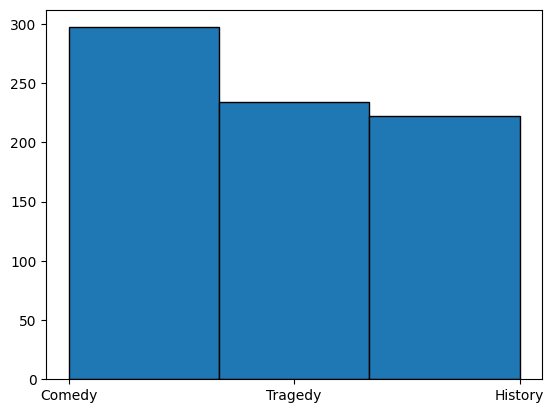

In [ ]:
plt.hist(scenes['genre'], bins=3,edgecolor='black')
plt.plot()

In [ ]:
Lemmatizer = WordNetLemmatizer()

def lemmatizer_tag(word): # Получение части речи в формате, который требует лемматизатор
  tag = pos_tag([word])[0][1][0].upper()
  tag_dict = {
      "J": "a",  # Прилагательное
      "N": "n",  # Существительное
      "R": "r",  # Наречие
      "V": "v",  # Глагол
    }
  return tag_dict.get(tag, "n")

def clean_text(text, normalization=False):
  text = text.lower() # Приведение к нижнему регистру
  words = word_tokenize(text) # Токенизация
  no_stop_words = [word for word in words if word not in set(stopwords.words('english')) and word.isalpha()] # Удаление стоп-слов и не-слов (цифр, спец знаков и т.п.)
  if normalization: # Лемматизация (метод нормализации) происходит, если того требует пользователь
    cleaned_words = [Lemmatizer.lemmatize(word, lemmatizer_tag(word)) for word in no_stop_words]
    return ' '.join(cleaned_words)
  return ' '.join(no_stop_words)

In [ ]:
scenes["clear text"] = scenes['text'].apply(clean_text)
scenes["normalized text"] = scenes['text'].apply(lambda x: clean_text(x, True))
scenes

,play_name,act,scene,text,genre,clear text,normalized text
0,A Midsummer Night's Dream,1,1,"Now, fair Hippolyta, our nuptial hour Draws on...",Comedy,fair hippolyta nuptial hour draws apace four h...,fair hippolyta nuptial hour draw apace four ha...
1,A Midsummer Night's Dream,1,2,Is all our company here? You were best to call...,Comedy,company best call generally man man according ...,company best call generally man man accord scr...
2,A Midsummer Night's Dream,2,1,"How now, spirit! whither wander you? Over hill...",Comedy,spirit whither wander hill dale thorough bush ...,spirit whither wander hill dale thorough bush ...
3,A Midsummer Night's Dream,2,2,"Come, now a roundel and a fairy song; Then, fo...",Comedy,come roundel fairy song third part minute henc...,come roundel fairy song third part minute henc...
4,A Midsummer Night's Dream,3,1,"Are we all met? Pat, pat; and here's a marvell...",Comedy,met pat pat marvellous convenient place rehear...,met pat pat marvellous convenient place rehear...
...,...,...,...,...,...,...,...
748,Winter's Tale,4,3,"I, that please some, try all, both joy and ter...",Comedy,please try joy terror good bad makes unfolds e...,please try joy terror good bad make unfolds er...
749,Winter's Tale,4,4,These your unusual weeds to each part of you D...,Comedy,unusual weeds part give life shepherdess flora...,unusual weed part give life shepherdess flora ...
750,Winter's Tale,5,1,"Sir, you have done enough, and have perform'd ...",Comedy,sir done enough perform sorrow fault could mak...,sir do enough perform sorrow fault could make ...
751,Winter's Tale,5,2,"Beseech you, sir, were you present at this rel...",Comedy,beseech sir present relation opening fardel he...,beseech sir present relation opening fardel he...


In [ ]:
scenes["class"] = scenes["genre"].replace({
    "Comedy": 0,
    "Tragedy": 1,
    "History": 2
})

# Классификация

Функция для создания датасета к нейронной сети с помощью векторизаторов

In [ ]:
def create_datasets_with_vectorizer(x, y, vectorizer, random_state=0):
  y = np.array(y)
  x_train, x_test, y_train, y_test = train_test_split(
      x,
      y,
      test_size=0.2,
      stratify=y,
      random_state=random_state
  )
  x_train = vectorizer.fit_transform(x_train).toarray()
  x_test = vectorizer.transform(x_test).toarray()
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train)
  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test)
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
  return (
      DataLoader(train_dataset, batch_size=10, shuffle=True),
      DataLoader(test_dataset, batch_size=10),
      len(vectorizer.vocabulary_) #Размерность словаря, для определения размера входного слоя нейронной сети
  )

Тестирование модели

In [ ]:
def test_model(train, test, model, epochs=10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()
  for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
    print(f"Эпоха: {epoch+1}, ошибка на обучении: {running_loss/len(train)}")
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
      for inputs, labels in test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    print(f"На валидации: {running_loss/len(test)}")

Классификатор

In [ ]:
class TextClassifier(nn.Module):
  def __init__(self, num_features):
    super(TextClassifier, self).__init__()
    self.fc1 = nn.Linear(num_features, 50)
    self.fc2 = nn.Linear(50, 20)
    self.fc3 = nn.Linear(20, 3)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    return self.fc3(x)

Метод "Мешок слов" (реализуется в CountVectorizer)

In [ ]:
train, test, voc_size = create_datasets_with_vectorizer(scenes['clear text'], scenes["class"], CountVectorizer()) # Тестирование на очищенных данных
test_model(train, test, TextClassifier(voc_size))

Эпоха: 1, ошибка на обучении: 0.8165904176039774
На валидации: 0.43625426094513386
Эпоха: 2, ошибка на обучении: 0.22717036471747962
На валидации: 0.28501152760600235
Эпоха: 3, ошибка на обучении: 0.08261343292493997
На валидации: 0.2140275083947909
Эпоха: 4, ошибка на обучении: 0.03846898190982378
На валидации: 0.1868422016268596
Эпоха: 5, ошибка на обучении: 0.019791144676196755
На валидации: 0.20462995680281848
Эпоха: 6, ошибка на обучении: 0.010084470154666991
На валидации: 0.17692400651867501
Эпоха: 7, ошибка на обучении: 0.005672789649042152
На валидации: 0.17600727558601648
Эпоха: 8, ошибка на обучении: 0.0036549304578761994
На валидации: 0.18427561467979103
Эпоха: 9, ошибка на обучении: 0.002266829033450464
На валидации: 0.1824433408328332
Эпоха: 10, ошибка на обучении: 0.0015510901260138213
На валидации: 0.1891253968133242


In [ ]:
train, test, voc_size = create_datasets_with_vectorizer(scenes['normalized text'], scenes["class"], CountVectorizer()) #Тестирование на очищенных и нормализованных данных
test_model(train, test, TextClassifier(voc_size))

Эпоха: 1, ошибка на обучении: 0.8567873801364273
На валидации: 0.4899788456968963
Эпоха: 2, ошибка на обучении: 0.2649561612137792
На валидации: 0.268916033156529
Эпоха: 3, ошибка на обучении: 0.08460113951234055
На валидации: 0.19033860438503325
Эпоха: 4, ошибка на обучении: 0.03313655950430567
На валидации: 0.17136915976880118
Эпоха: 5, ошибка на обучении: 0.018224676906133115
На валидации: 0.17440474980685394
Эпоха: 6, ошибка на обучении: 0.009509847466390175
На валидации: 0.16267989471089095
Эпоха: 7, ошибка на обучении: 0.006676771090049621
На валидации: 0.16603367372590583
Эпоха: 8, ошибка на обучении: 0.00354915353198551
На валидации: 0.16639806274906732
Эпоха: 9, ошибка на обучении: 0.002405199351452662
На валидации: 0.16809347704111133
Эпоха: 10, ошибка на обучении: 0.0017270896328413908
На валидации: 0.17160202801096602


Метод Tf-Idf (реализуется в TfidfVectorizer)

In [ ]:
train, test, voc_size = create_datasets_with_vectorizer(scenes['clear text'], scenes["class"], TfidfVectorizer()) # Тестирование на очищенных данных
test_model(train, test, TextClassifier(voc_size))

Эпоха: 1, ошибка на обучении: 1.0764370902639921
На валидации: 1.0118381939828396
Эпоха: 2, ошибка на обучении: 0.81581769028648
На валидации: 0.7088958919048309
Эпоха: 3, ошибка на обучении: 0.3518829373795478
На валидации: 0.37879200000315905
Эпоха: 4, ошибка на обучении: 0.08665795819681199
На валидации: 0.2514916816726327
Эпоха: 5, ошибка на обучении: 0.026300429152782825
На валидации: 0.20545006496831775
Эпоха: 6, ошибка на обучении: 0.011164844217404846
На валидации: 0.1828083759173751
Эпоха: 7, ошибка на обучении: 0.005809452415245478
На валидации: 0.16789224208332598
Эпоха: 8, ошибка на обучении: 0.003354117554826204
На валидации: 0.1601485456340015
Эпоха: 9, ошибка на обучении: 0.0022749207335615866
На валидации: 0.15849663395783864
Эпоха: 10, ошибка на обучении: 0.0015795758312766547
На валидации: 0.1532257554354146


In [ ]:
train, test, voc_size = create_datasets_with_vectorizer(scenes['normalized text'], scenes["class"], TfidfVectorizer()) #Тестирование на очищенных и нормализованных данных
test_model(train, test, TextClassifier(voc_size))

Эпоха: 1, ошибка на обучении: 1.0743036660991732
На валидации: 1.0173889435827732
Эпоха: 2, ошибка на обучении: 0.7927717253810069
На валидации: 0.6359752211719751
Эпоха: 3, ошибка на обучении: 0.2962732897674451
На валидации: 0.3190741706639528
Эпоха: 4, ошибка на обучении: 0.07072818422781639
На валидации: 0.22782435058616102
Эпоха: 5, ошибка на обучении: 0.025403226130321376
На валидации: 0.19247735862154514
Эпоха: 6, ошибка на обучении: 0.012189384175800398
На валидации: 0.16926163781317882
Эпоха: 7, ошибка на обучении: 0.006283632704804911
На валидации: 0.1552375144965481
Эпоха: 8, ошибка на обучении: 0.003936733323393665
На валидации: 0.14622782208607532
Эпоха: 9, ошибка на обучении: 0.0026888282555460807
На валидации: 0.14023541147616925
Эпоха: 10, ошибка на обучении: 0.001957085679216524
На валидации: 0.1365227314963704


Word2Vec

Загрузка предварительно обученной модели

In [ ]:
w2v = downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Функция для конвертации предложения в вектор векторов слов

In [ ]:
def text_to_vectors(text, model, max_len):
    words = text.split()
    words = words[:max_len] + ['<pad>'] * (max_len - len(words))
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
        else:
            vectors.append(np.zeros(model.vector_size))
    return vectors

Длины текстов

In [ ]:
scenes['clear text'].apply(lambda x: len(x.split())).median() # Медиана длины текста

404.0

Создание датасетов

In [ ]:
def create_datasets_with_word2vec(x, y, model, random_state=0):
  y = np.array(y)
  x_train, x_test, y_train, y_test = train_test_split(
      x,
      y,
      test_size=0.2,
      stratify=y,
      random_state=random_state
  )
  x_train_vec = x_train.apply(lambda x: text_to_vectors(x, model, 404))
  x_test_vec = x_test.apply(lambda x: text_to_vectors(x, model, 404))
  x_train_tensor = torch.tensor(x_train_vec.tolist(), dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train)
  x_test_tensor = torch.tensor(x_test_vec.tolist(), dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test)
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
  return (
      DataLoader(train_dataset, batch_size=10, shuffle=True),
      DataLoader(test_dataset, batch_size=10)
  )

LSTM нейронная сеть

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        last_hidden = hidden[-1]
        out = self.fc(last_hidden)
        return out

Проверка модели на очищенных данных

In [ ]:
train, test = create_datasets_with_word2vec(scenes['clear text'], scenes['class'], w2v)
test_model(train, test, LSTMClassifier(300, 50, 3))

<ipython-input-22-6be05f559b93>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_train_tensor = torch.tensor(x_train_vec.tolist(), dtype=torch.float32)


Эпоха: 1, ошибка на обучении: 1.091269114955527
На валидации: 1.0959249883890152
Эпоха: 2, ошибка на обучении: 1.0769662700715612
На валидации: 1.0984126143157482
Эпоха: 3, ошибка на обучении: 1.0502074693070083
На валидации: 1.0833654627203941
Эпоха: 4, ошибка на обучении: 1.0607337912575143
На валидации: 1.0949301347136497
Эпоха: 5, ошибка на обучении: 0.9946748389572394
На валидации: 1.063386157155037
Эпоха: 6, ошибка на обучении: 0.9403776311483539
На валидации: 1.0770019888877869
Эпоха: 7, ошибка на обучении: 0.905201195693407
На валидации: 1.092695988714695
Эпоха: 8, ошибка на обучении: 0.8726354866731362
На валидации: 1.048977766185999
Эпоха: 9, ошибка на обучении: 0.79626599735901
На валидации: 1.126905120909214
Эпоха: 10, ошибка на обучении: 0.74567405048941
На валидации: 1.079479180276394


In [ ]:
train, test = create_datasets_with_word2vec(scenes['normalized text'], scenes['class'], w2v)
test_model(train, test, LSTMClassifier(300, 50, 3))

Эпоха: 1, ошибка на обучении: 1.0975328644768136
На валидации: 1.0999520272016525
Эпоха: 2, ошибка на обучении: 1.0768315469632384
На валидации: 1.1014836840331554
Эпоха: 3, ошибка на обучении: 1.0546916430113746
На валидации: 1.1056623607873917
Эпоха: 4, ошибка на обучении: 1.014148112203254
На валидации: 1.0796936862170696
Эпоха: 5, ошибка на обучении: 0.9591752632719571
На валидации: 1.0294394418597221
Эпоха: 6, ошибка на обучении: 0.9287761361872564
На валидации: 1.0911539234220982
Эпоха: 7, ошибка на обучении: 0.8391894336606636
На валидации: 1.04669938236475
Эпоха: 8, ошибка на обучении: 0.7528208459987015
На валидации: 1.1497726142406464
Эпоха: 9, ошибка на обучении: 0.7502058734659289
На валидации: 1.1384675465524197
Эпоха: 10, ошибка на обучении: 0.6612255614800532
На валидации: 1.049690816551447
